In [1]:
from itertools import cycle,islice

from matplotlib import pylab as plt
import numpy as np
import sklearn
import sklearn.datasets

import torch
import torch.nn as nn
import torchvision
import torchdiffeq

import odenet
import odenet.models as models
import odenet.ode_models as ode_models
import odenet.plotting as plotting
import odenet.refine_train as refine_train

In [2]:
import importlib
importlib.reload(models)
importlib.reload(ode_models)
importlib.reload(refine_train)

<module 'odenet.refine_train' from '/home/ubuntu/afq/ODENet/odenet/refine_train.py'>

In [3]:
colors = np.array(list(islice(cycle(
    ['#377eb8', '#ff7f00', '#4daf4a',
     '#f781bf', '#a65628', '#984ea3',
     '#999999', '#e41a1c', '#dede00']),
    int(max([1]) + 1))))

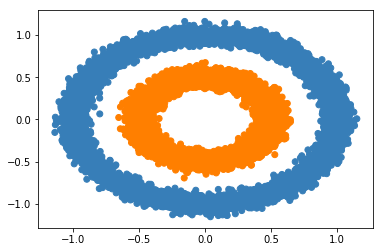

In [4]:
X,Y = sklearn.datasets.make_circles(n_samples=15000, factor=.5,
                                      noise=.05)
plt.scatter(X[:,0],X[:,1],color=colors[Y])

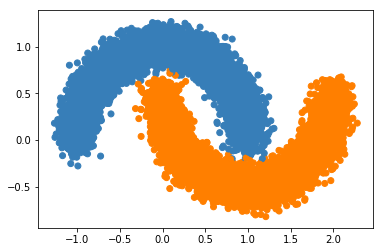

In [5]:
X,Y = sklearn.datasets.make_moons(n_samples=15000,noise=0.1)

plt.scatter(X[:,0],X[:,1],color=colors[Y])

In [6]:
def plot_pred(model):
    pred = torch.sigmoid(model( torch.tensor(X[:1000,:],dtype=torch.float32) ))
    P = pred.detach().numpy()
    P = np.array(np.around(P),dtype=np.int)
    plt.scatter(X[:1000,0],X[:1000,1],color=colors[list(P.flatten())])

In [7]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(X,dtype=torch.float),torch.tensor(Y,dtype=torch.float).reshape(-1,1))
loader = torch.utils.data.DataLoader(dataset,batch_size=64)

In [8]:
model_deep = models.DeepNet((2,4,4,4,1),Act=torch.nn.LeakyReLU)

In [9]:
class ODEModel(torch.nn.Module):
    def __init__(self,i_dim,o_dim,ode_width=4,
                 inside_width=4,Act=torch.nn.ReLU,
                method='euler'):
        super(ODEModel,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(i_dim,ode_width),
            odenet.ODEBlock(
                odenet.ShallowODE(1,ode_width,ode_width,act=torch.nn.functional.leaky_relu),
                method='euler'),
            torch.nn.Linear(ode_width,o_dim),
        )
    def forward(self,x):
        # Missing sigmoid
        y = self.net(x)
        return y
    def refine(self):
        new = copy.deepcopy(self)
        new.net[1] = models.refine(self.net[1])
        return new

In [10]:
model_shallow = models.ShallowNet(2,1,hidden=8,Act=torch.nn.LeakyReLU)
losses = refine_train.train_for_epochs(
    model_shallow, loader, loader, nn.BCEWithLogitsLoss(), 5, lr = 0.01)

Connected to device  cuda:0


RuntimeError: cuda runtime error (100) : no CUDA-capable device is detected at /pytorch/aten/src/THC/THCGeneral.cpp:47

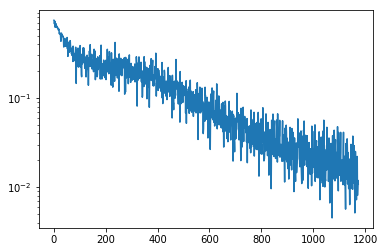

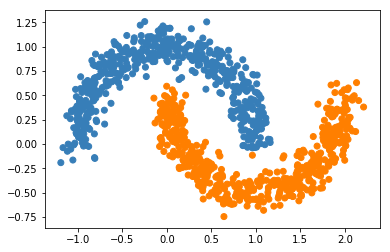

In [125]:
plt.semilogy(losses)
plt.show()
plot_pred(model_shallow)

In [138]:
model = ODEModel(2,1,ode_width=4,inside_width=8,
                 Act=torch.nn.LeakyReLU,method='rk4')

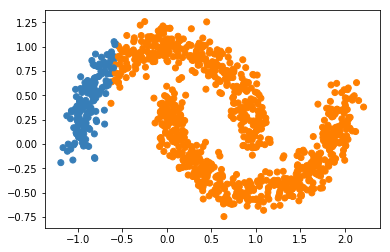

In [139]:
losses = train_for_epochs(model, 5, lr=0.01)

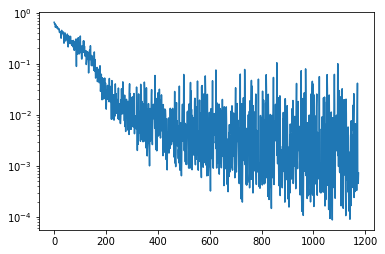

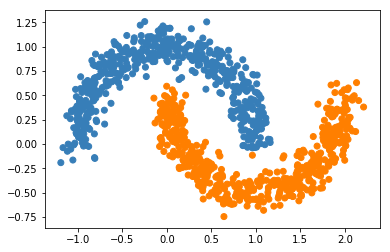

In [140]:
plt.semilogy(losses)
plt.show()
plot_pred(model_shallow)

In [141]:
model_refine = ODEModel(2,1,ode_width=4,inside_width=8,
                 Act=torch.nn.LeakyReLU,method='rk4')

Starting with  57 with lr =  0.1


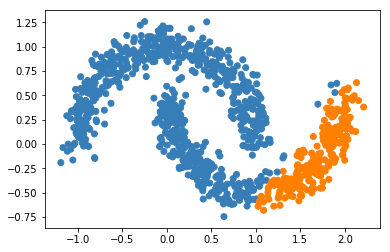

Adapting to  97 with lr =  0.1


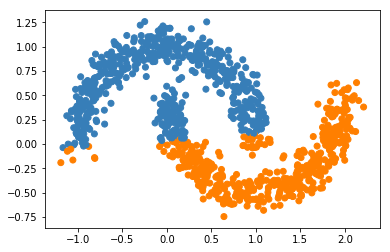

Adapting to  177 with lr =  0.01


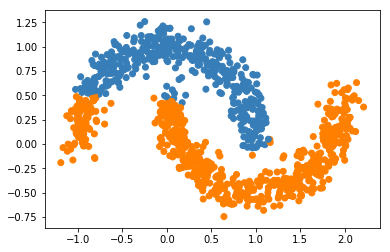

Adapting to  337 with lr =  0.01


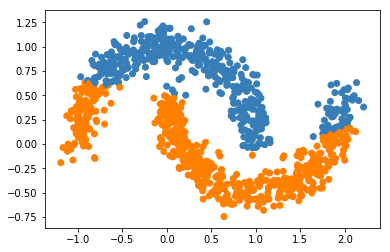

In [143]:
model_list, losses, refine_steps = train_adapt(model_refine,1,4)

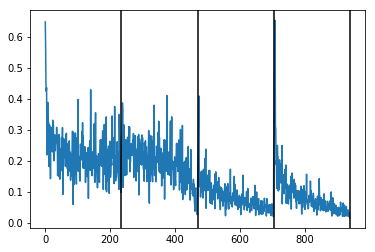

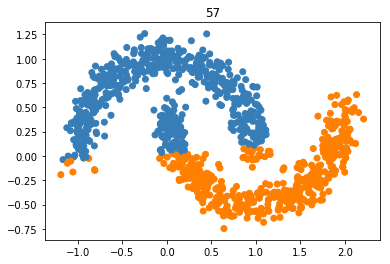

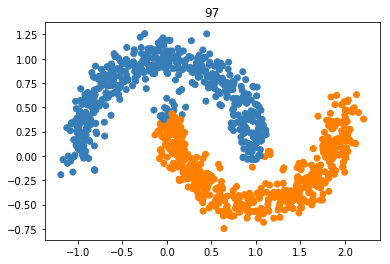

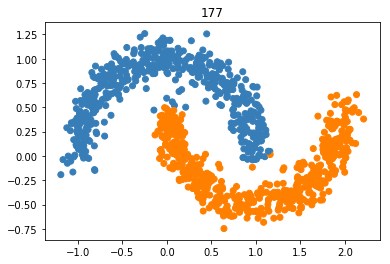

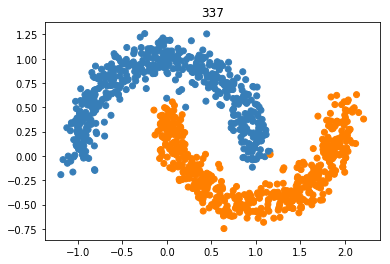

In [144]:
plt.plot(losses)
for r in refine_steps:
    plt.axvline(r,color='k')
plt.show()
for m in model_list:
    plt.title(models.count_parameters(m))
    plot_pred(m)
    plt.show()

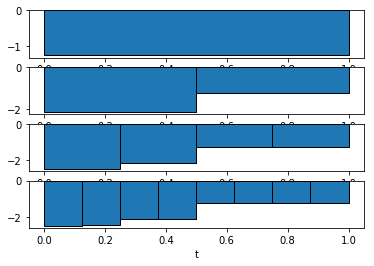

In [151]:
plot_weights_over_time(model_list, lambda x : x.net[1].net.L1.weights[:,0,2])